In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
from ANEMO import read_edf
from ANEMO import ANEMO

from scipy import stats

%matplotlib inline

In [2]:
sujet = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']
time = ['2017-10-23_100057','2017-09-26_095637', '2017-10-03_134421','2017-09-27_161040',
        '2017-10-03_143803','2017-09-28_115250', '2017-09-20_151043','2017-10-26_121823',
        '2017-11-08_094717','2017-11-16_153313', '2017-11-08_150410','2017-11-17_172706']

In [3]:
file = os.path.join('parametre', 'Delete_list_trials_velocity_fct.pkl')
with open(file, 'rb') as fichier :
    Delete_list_trials = pickle.load(fichier, encoding='latin1')

file = os.path.join('parametre', 'Delete_list_Bad_trials_velocity.pkl')
#file = os.path.join('parametre', 'Delete_list_Bad_trials_position.pkl')
with open(file, 'rb') as fichier :
    Bad_Fit = pickle.load(fichier, encoding='latin1')

In [4]:
for s in ['LB']:
    print(Bad_Fit[s], Delete_list_trials[s])

[[29, 36, 50, 52, 94, 100, 163, 170, 176, 190, 196, 198], [68, 72, 85, 91, 92, 132, 133, 135, 150, 155, 188], [52, 95, 113, 146, 154, 163]] [[10, 42, 82, 83, 90, 143, 150, 151, 163, 179], [72, 116, 118, 123, 162, 164, 178], [5, 11, 21, 32, 44, 53, 98]]


sujet[x] LB


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


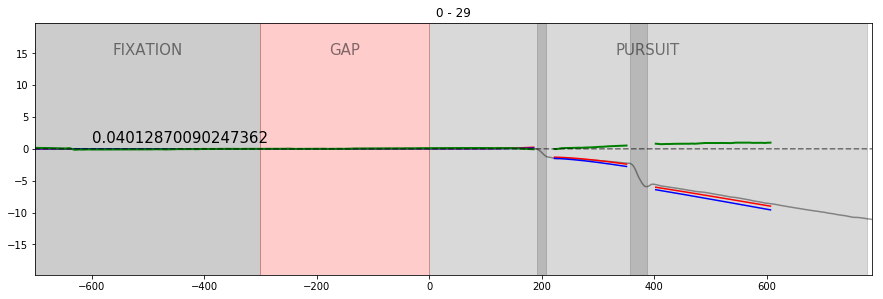

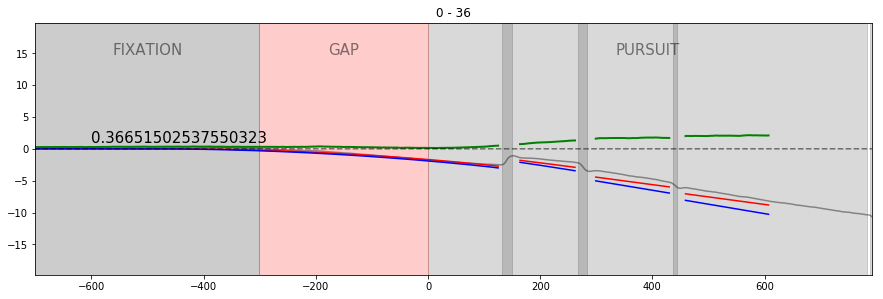

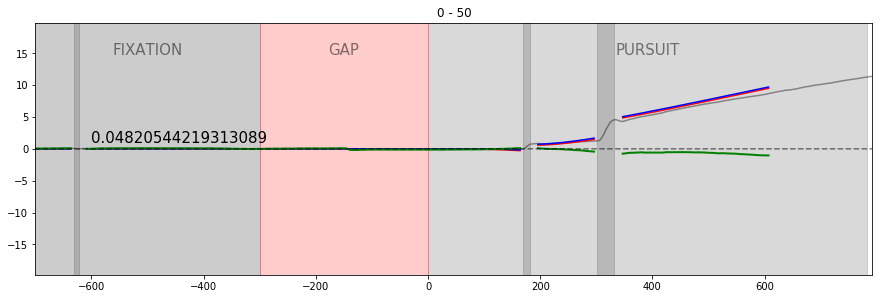

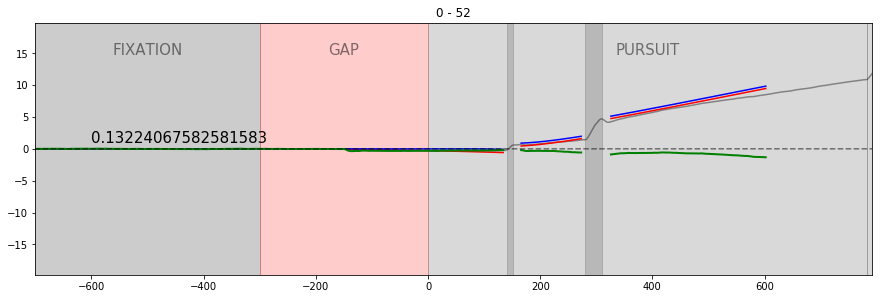

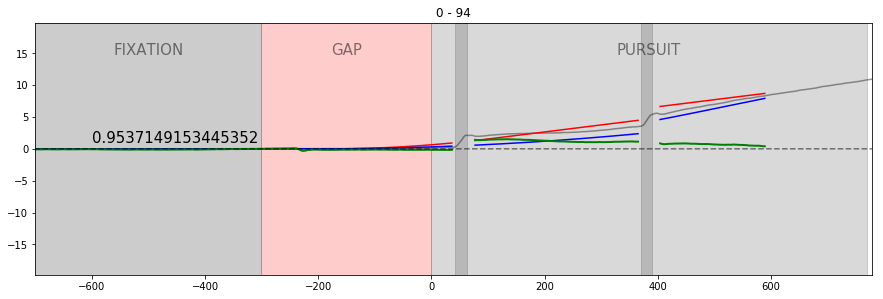

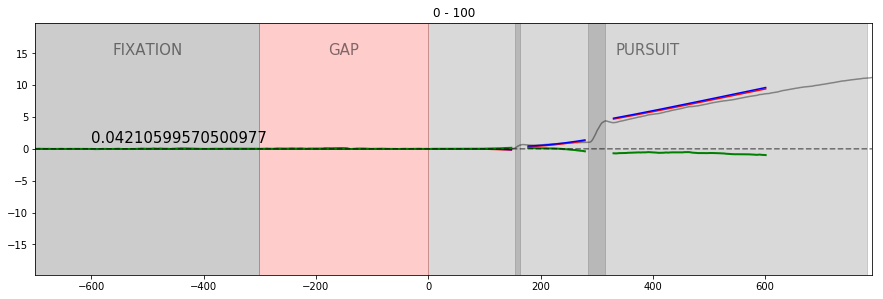

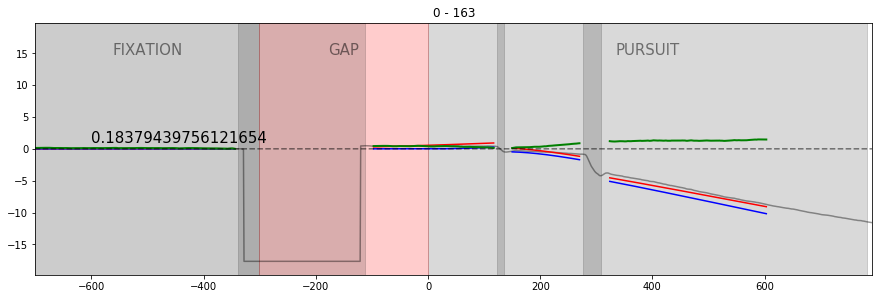

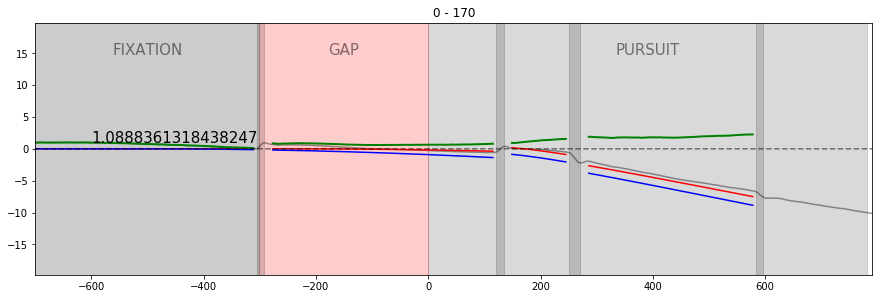

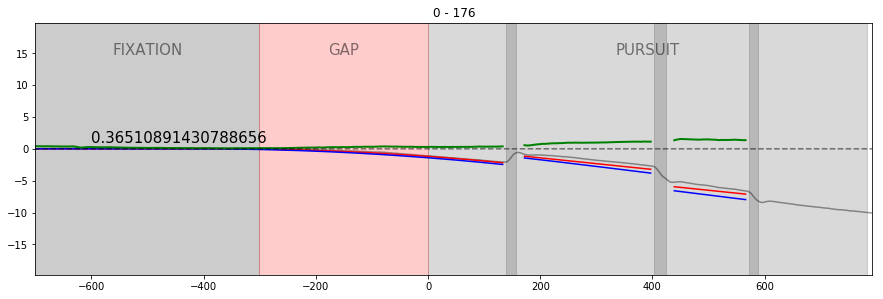

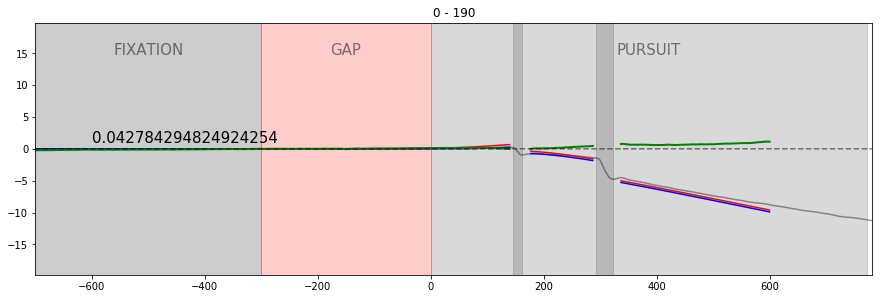

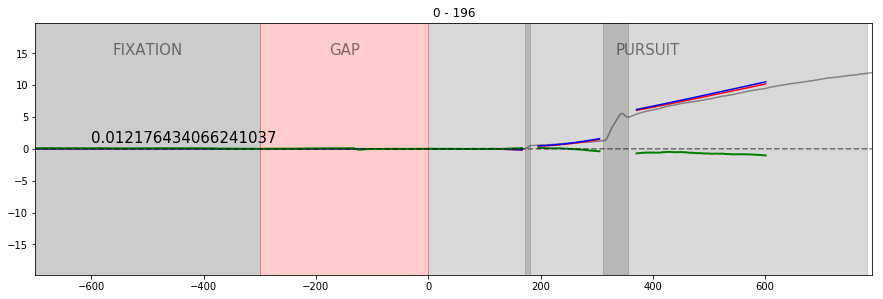

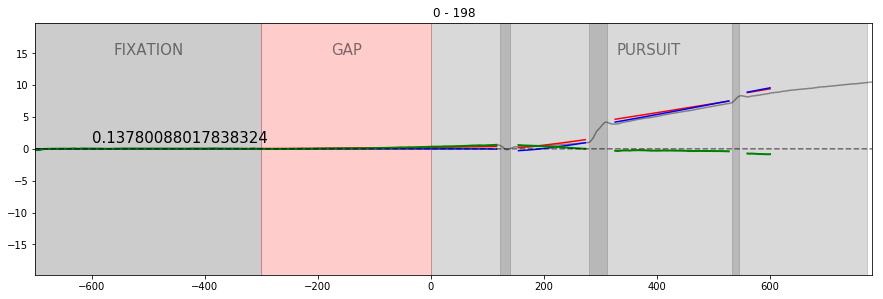

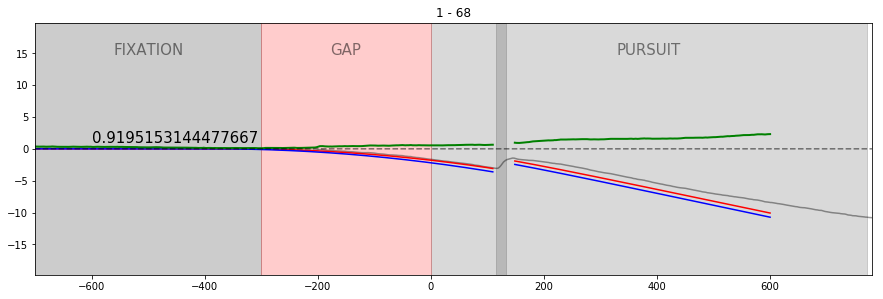

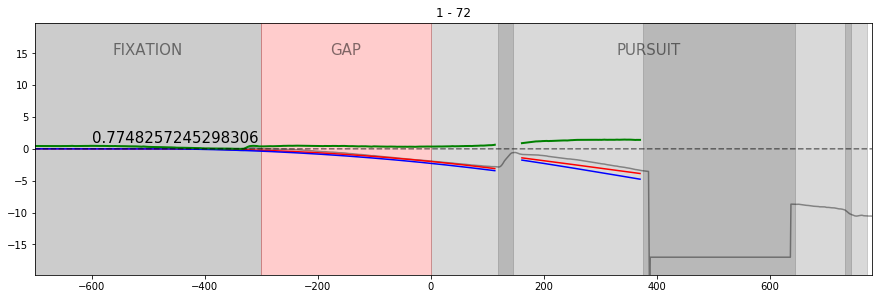

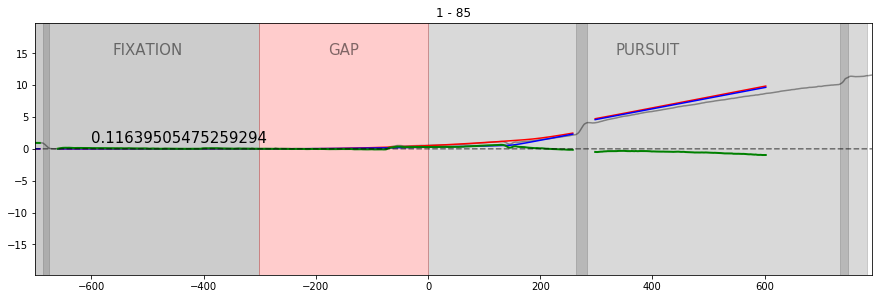

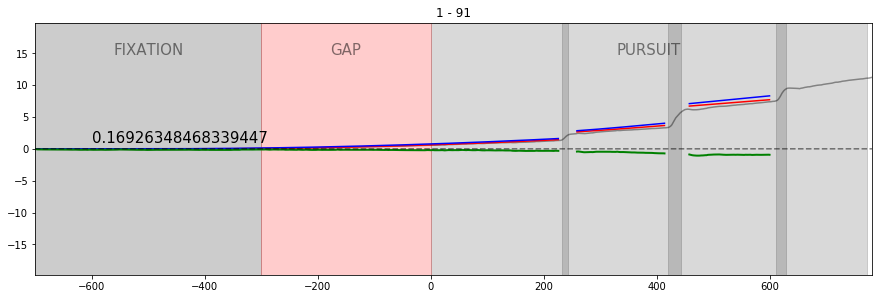

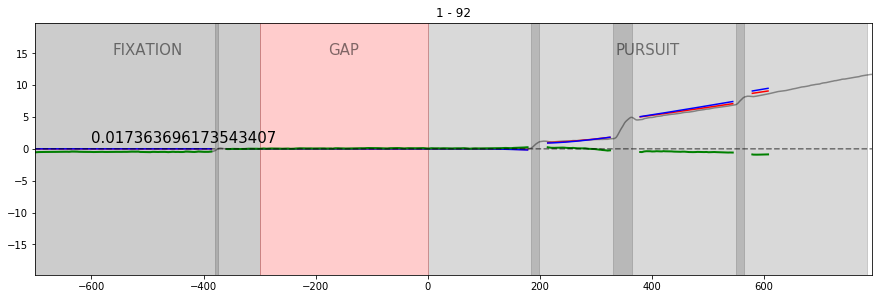

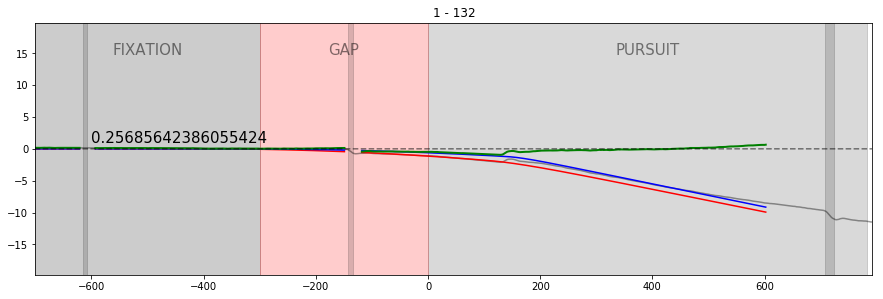

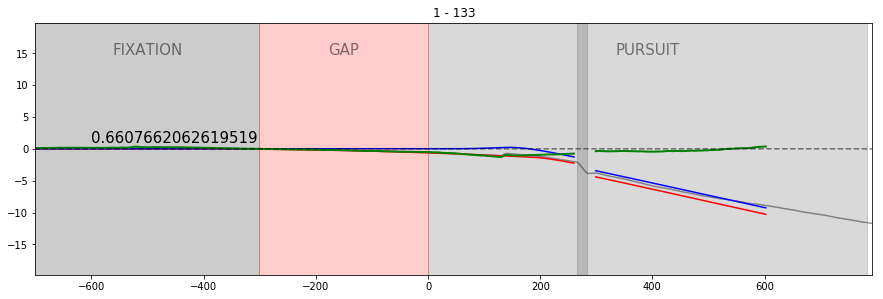

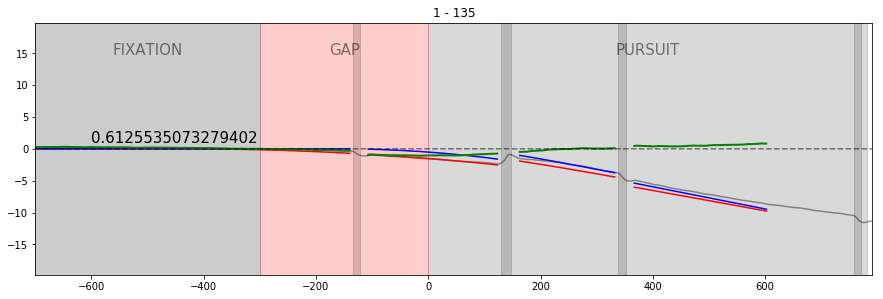

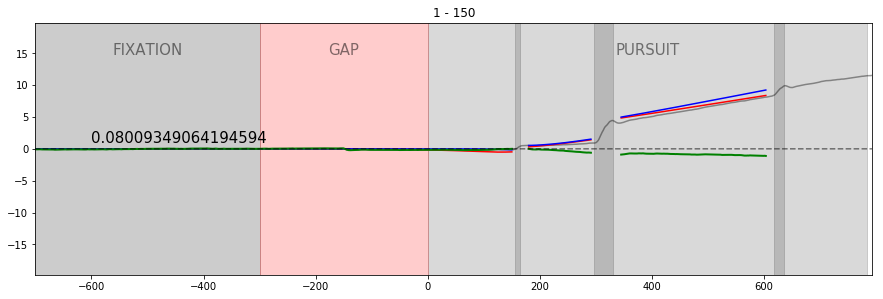

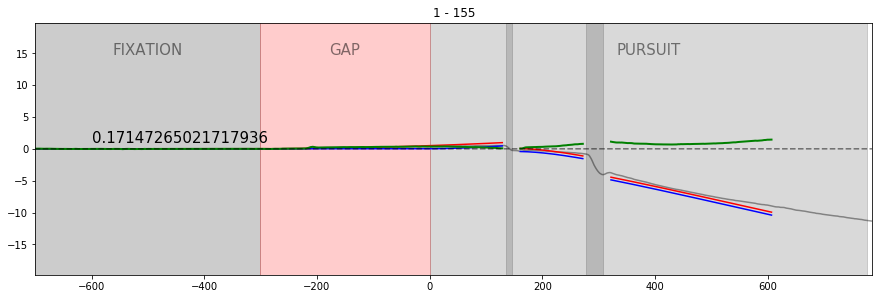

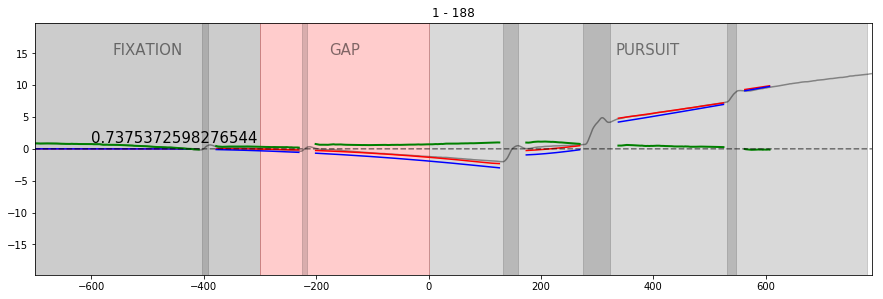

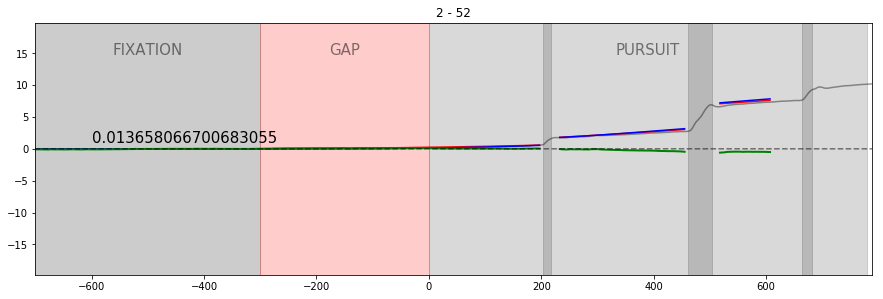

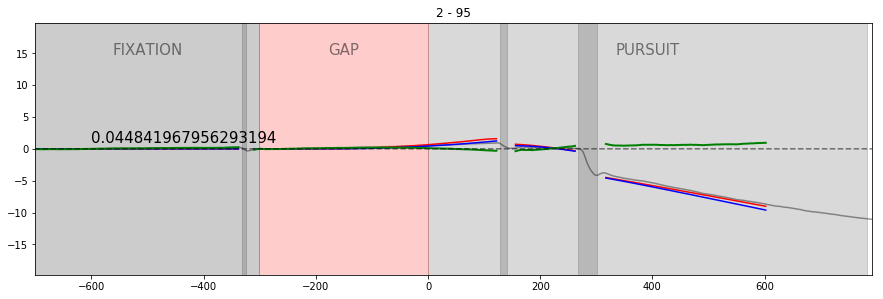

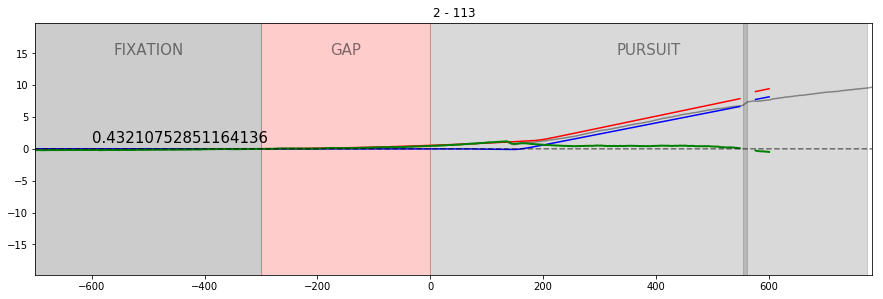

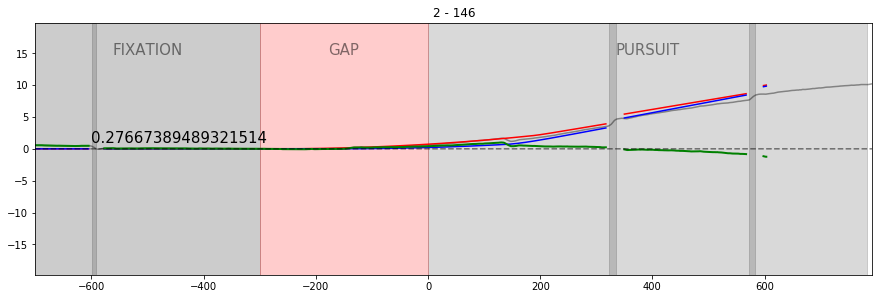

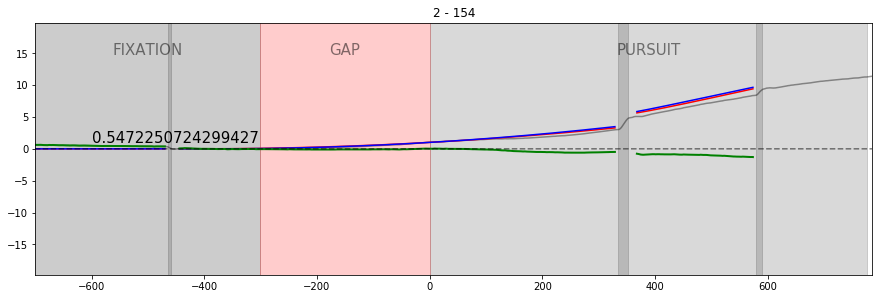

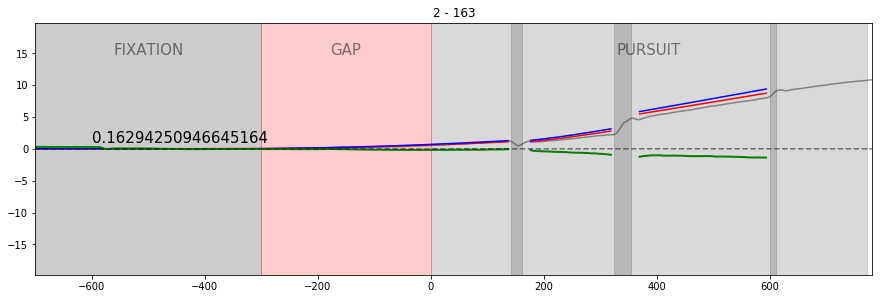

In [5]:
#for sujet in ['LB']:
for x in [6] : #range(len(sujet)) :
    print('sujet[x]', sujet[x])
    file = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.pkl')
    with open(file, 'rb') as fichier : param_exp = pickle.load(fichier, encoding='latin1')
    
    resultats = os.path.join('data', 'enregistrement_' + sujet[x] + '_' + time[x] + '.asc')
    data = read_edf(resultats, 'TRIALID')

    file = os.path.join('parametre/param_Fit_'+ sujet[x] +'_fct_velocity_2_step_False_whitening.pkl')
    with open(file, 'rb') as fichier : param_fit1 = pickle.load(fichier, encoding='latin1')

    file = os.path.join('parametre/param_Fit_'+ sujet[x] +'_fct_position_2_step_False_whitening.pkl')
    with open(file, 'rb') as fichier : param_fit2 = pickle.load(fichier, encoding='latin1')

    
    A = ANEMO(param_exp)
    Plot = A.Plot(param_exp)
    
    N_trials, N_blocks = param_exp['N_trials'], param_exp['N_blocks']

    for block in range(3) :
        for trial in Bad_Fit[sujet[x]][block] :

            trial_data = trial + N_trials*block
            arg = A.arg(data[trial_data], trial=trial, block=block)

            fig, ax = Plot.plot_data(data, show='positon', trials=trial, block=block)

            onset = arg.TargetOn-arg.t_0
            xx = np.arange(len(arg.trackertime))

            for param_fit, color in zip([param_fit2, param_fit1], ['r', 'b']):
                start_anti = int(param_fit['start_anti'][block][trial] + onset)
                a_anti = param_fit['a_anti'][block][trial]

                latency = int(param_fit['latency'][block][trial] + onset)
                tau = param_fit['tau'][block][trial]
                maxi = param_fit['maxi'][block][trial]

                sacc = np.zeros(len(arg.trackertime))
                i=0
                for s in range(len(arg.saccades)):
                    sacc[i]   = arg.saccades[s][0] # onset sacc
                    sacc[i+1] = arg.saccades[s][1] # end sacc
                    sacc[i+2] = arg.saccades[s][2] # time sacc
                    i = i+3


                fit = A.Equation.fct_position(xx, arg.data_x, sacc, len(arg.saccades),
                                              arg.dir_target, start_anti , a_anti,
                                              latency, tau, maxi, arg.t_0,
                                              arg.px_per_deg, before_sacc=5.,
                                              after_sacc=15., do_whitening=False)

                ax.plot(arg.trackertime[:-280]-arg.TargetOn, fit[:-280], c=color)
            
            
            
            
            d_x = A.data_deg(arg.data_x, arg.StimulusOf,arg.t_0, arg.saccades, before_sacc=5, after_sacc=15)
            
            ax.plot(arg.trackertime[:-280]-arg.TargetOn, d_x[:-280]-fit[:-280], 'green', lw=2)
            
            ax.plot(arg.trackertime-arg.TargetOn, np.zeros(len(arg.trackertime)), '--k', alpha=.5)
            
            start, stop = latency-200, latency+200
            d_x_ss_nan = np.ma.masked_array(d_x[start:stop], mask=np.isnan(fit[start:stop])).compressed()
            fit_ss_nan = np.ma.masked_array(fit[start:stop], mask=np.isnan(fit[start:stop])).compressed()
            
            
            #ax.plot(arg.trackertime[start_anti:start_anti+len(d_x_ss_nan)]-arg.TargetOn, d_x_ss_nan, 'c')
            #ax.plot(arg.trackertime[start_anti:start_anti+len(fit_ss_nan)]-arg.TargetOn, fit_ss_nan, 'c')
            #ax.plot(arg.trackertime[start_anti:start_anti+len(fit_ss_nan)]-arg.TargetOn, d_x_ss_nan-fit_ss_nan, 'c')
            
            #ax.text(-600, 10, np.nanmean(d_x[start_anti:-280]-fit[start_anti:-280]), fontsize=15)
            #ax.text(-600, 7, np.nanmean(abs(d_x[start_anti:-280]-fit[start_anti:-280])), fontsize=15)
            
            #ax.text(-600, 11, np.nanmean(d_x_ss_nan-fit_ss_nan), fontsize=15)
            #ax.text(-600, 8, np.nanmean(abs(d_x_ss_nan-fit_ss_nan)), fontsize=15)
            ax.text(-600, 1, np.nanmean((d_x_ss_nan-fit_ss_nan)**2), fontsize=15)            
            #ax.text(-600, 2, np.corrcoef(d_x_ss_nan, fit_ss_nan)[0][1] , fontsize=15)
            
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title('%s - %s'%(block,trial))
            #ax.set_ylim(-5, 5)
            

sujet[x] LB


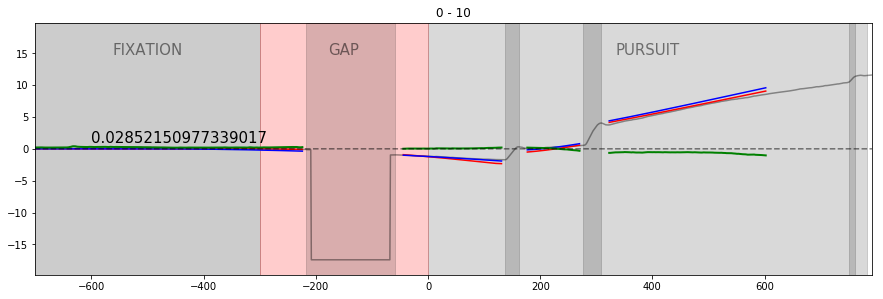

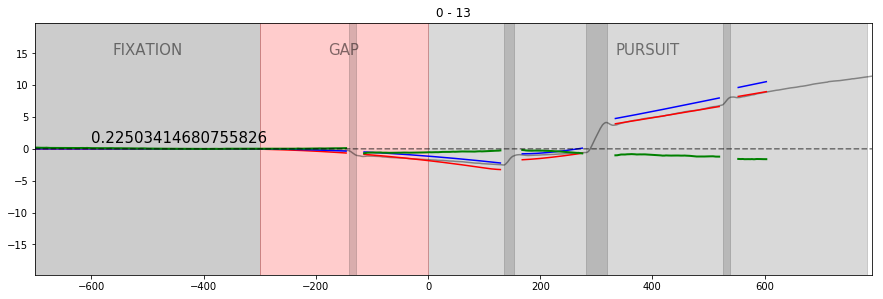

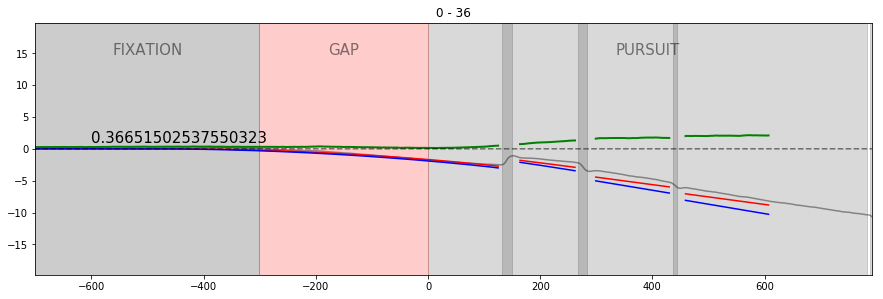

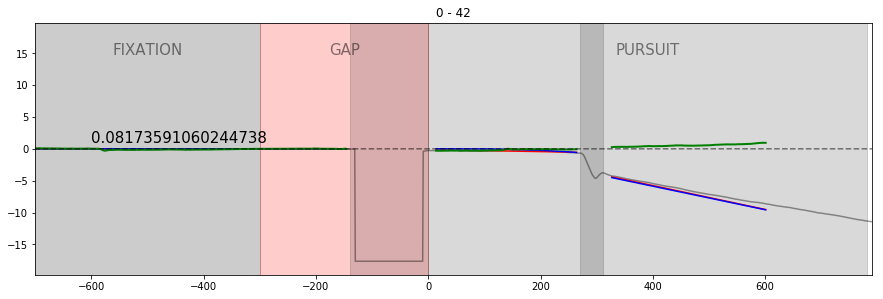

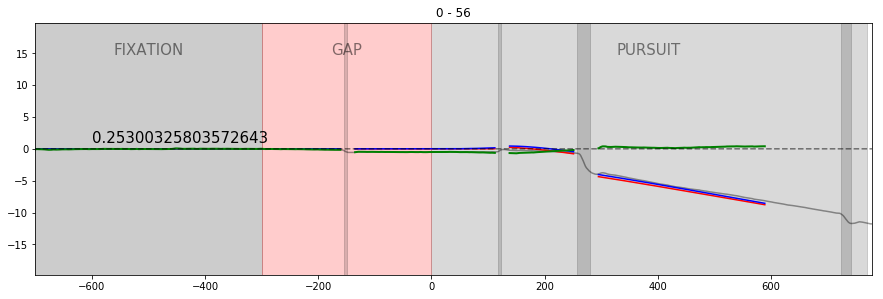

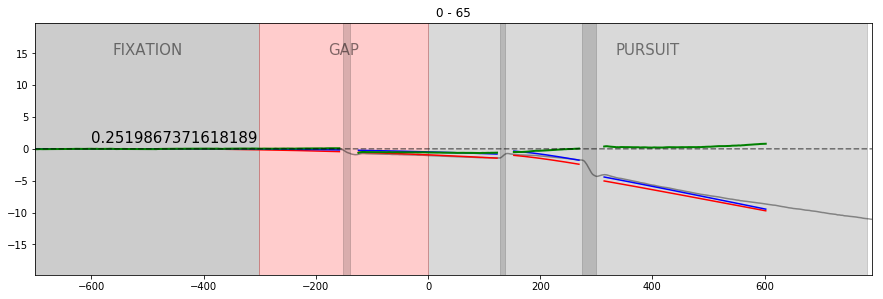

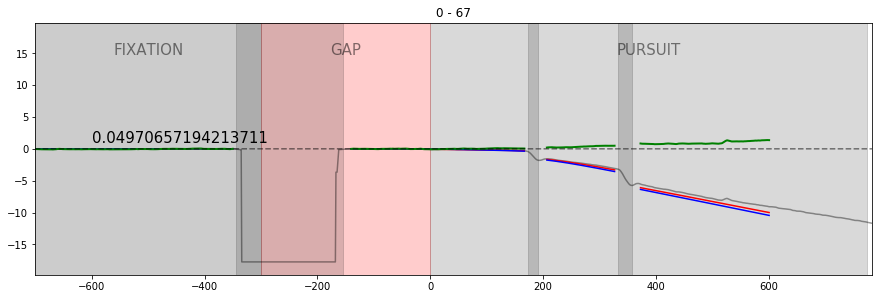

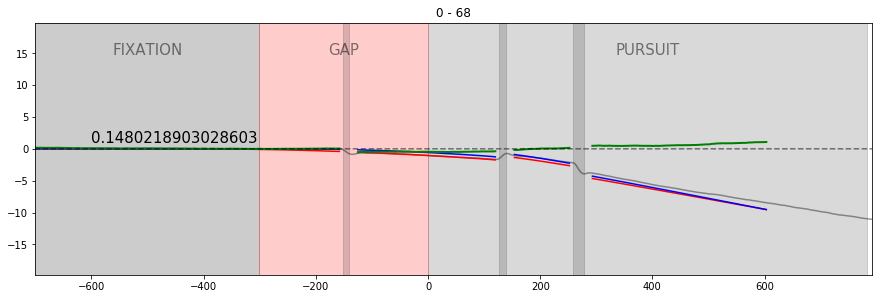

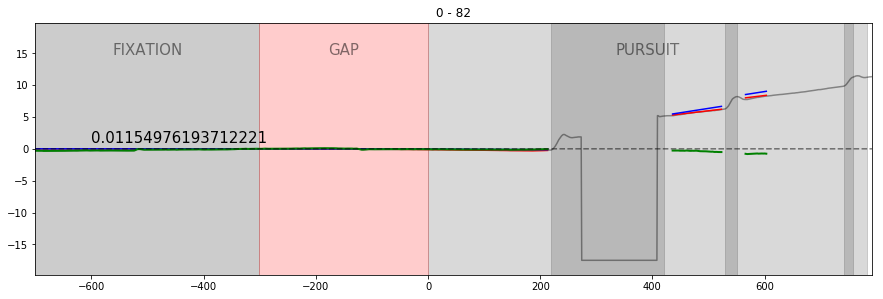

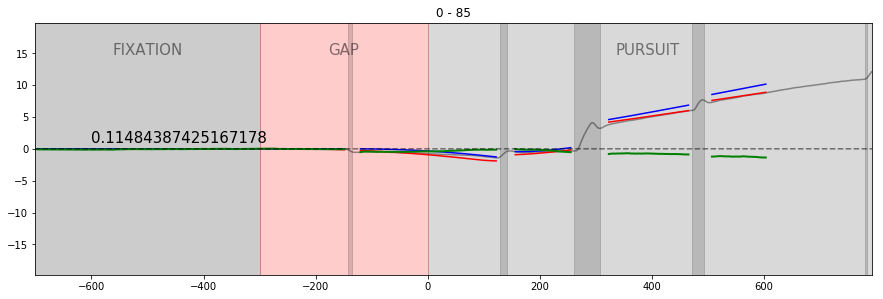

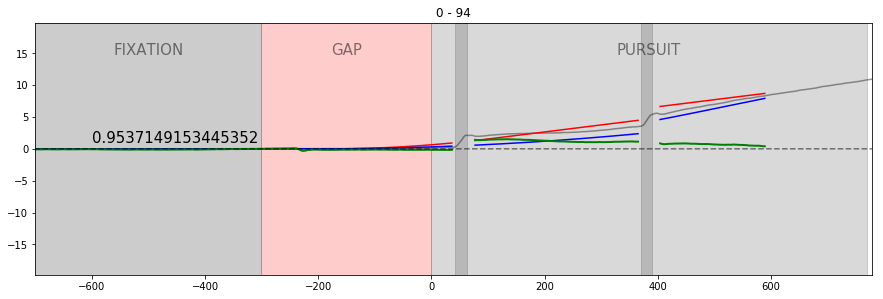

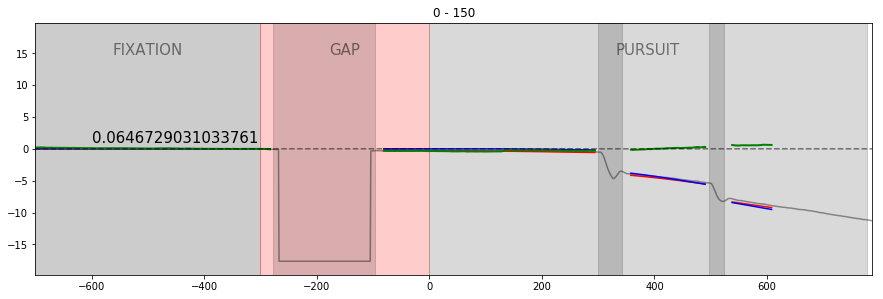

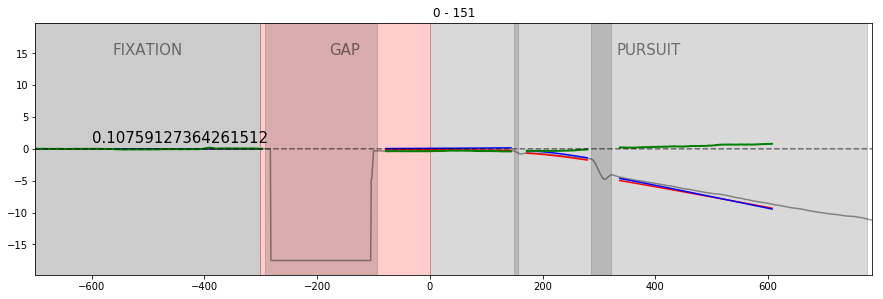

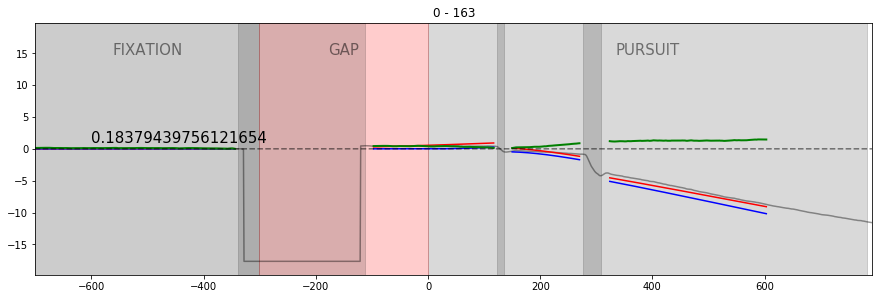

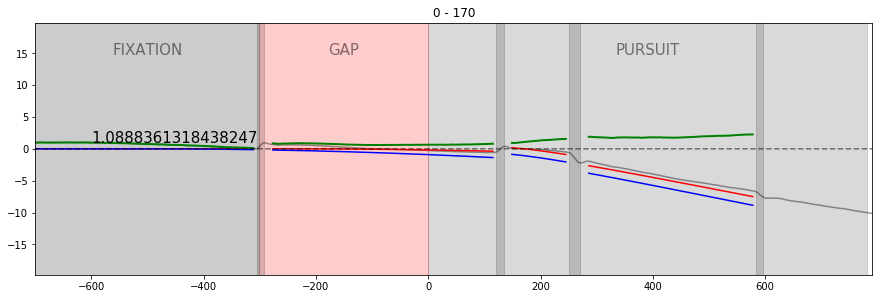

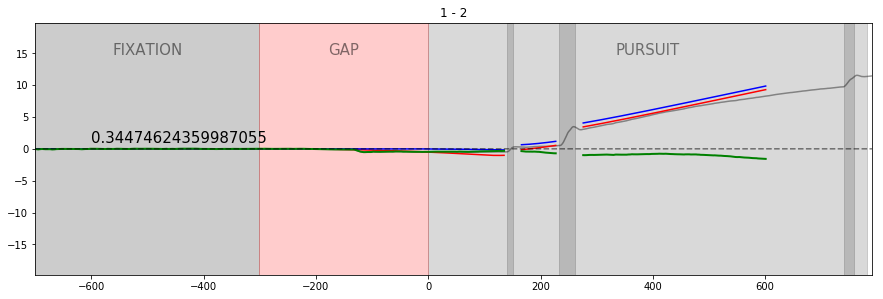

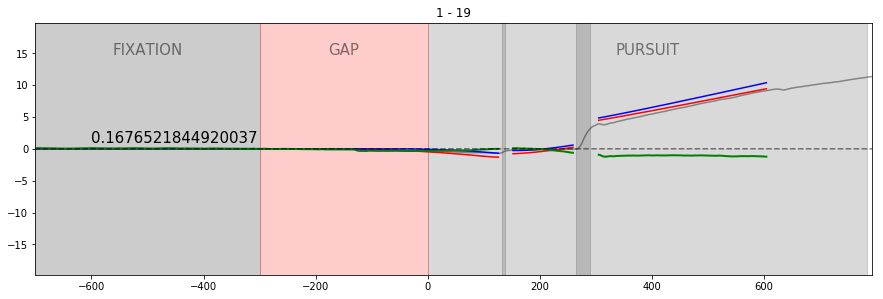

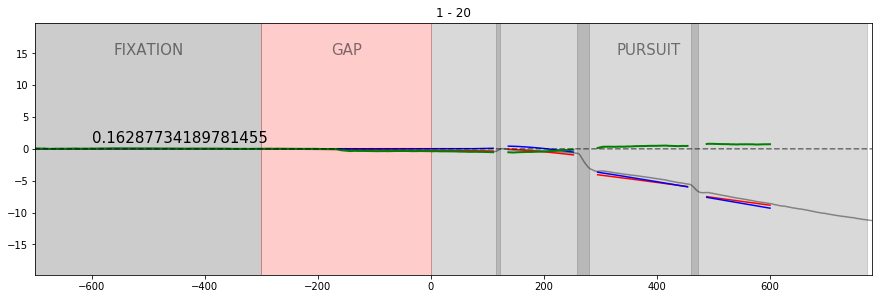

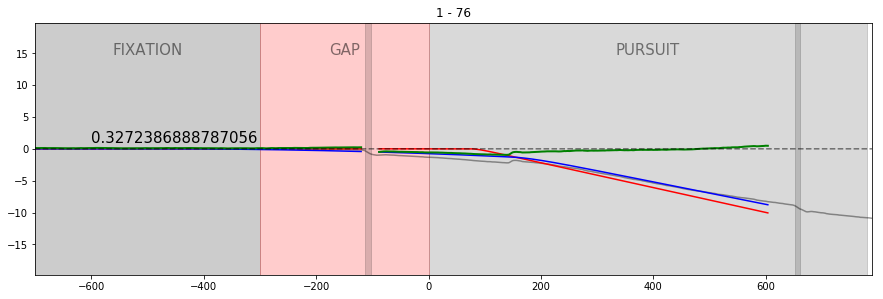

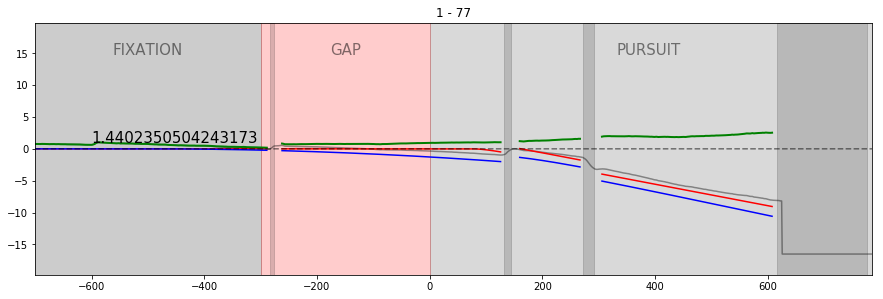

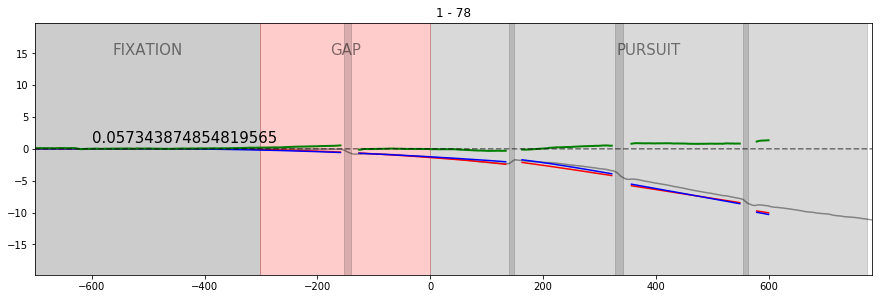

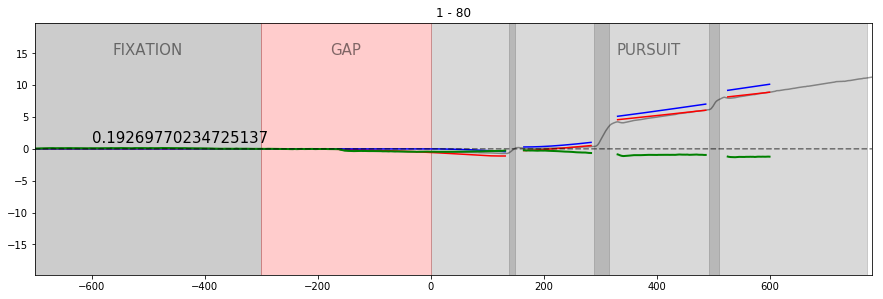

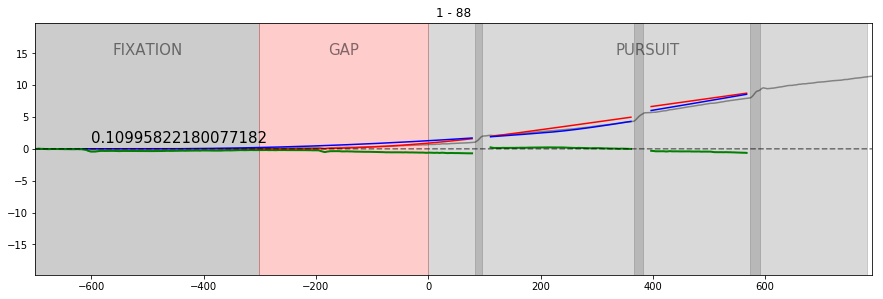

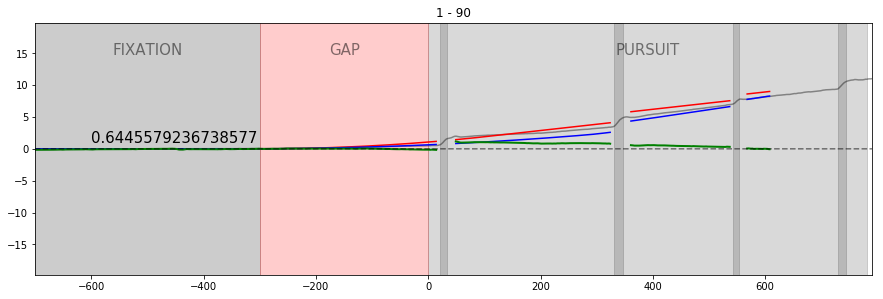

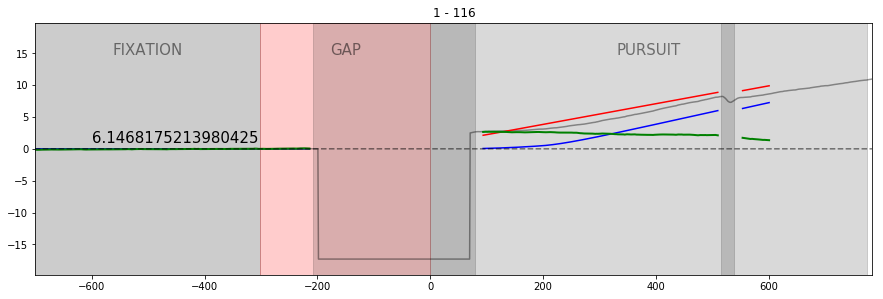

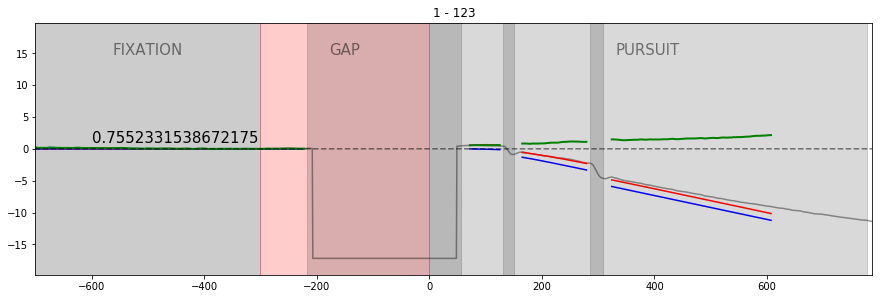

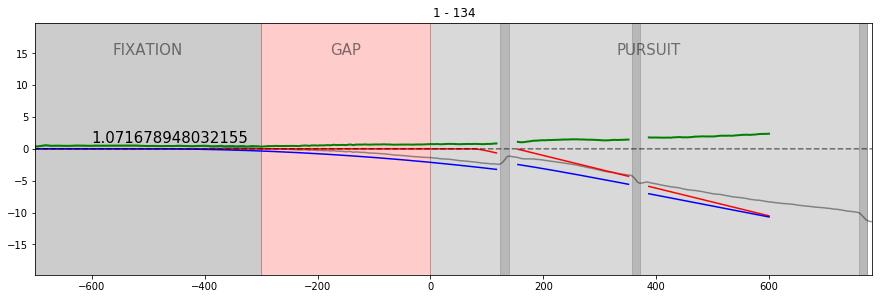

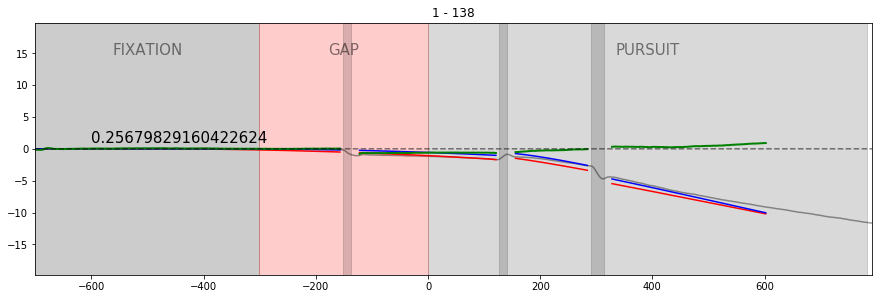

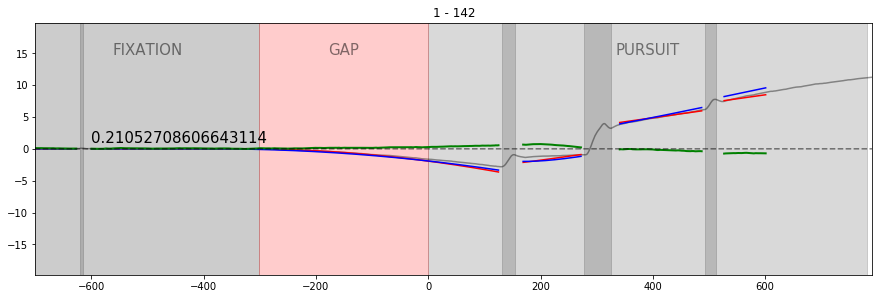

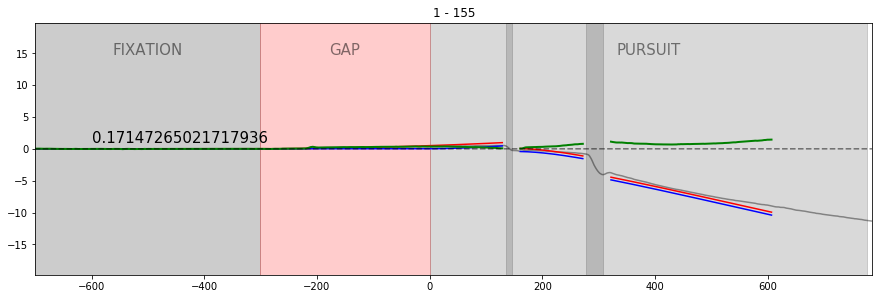

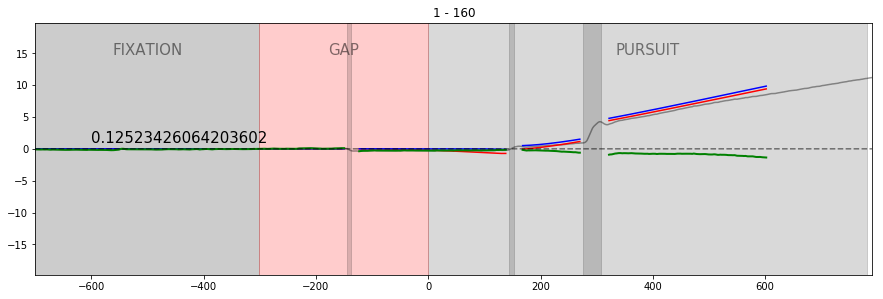

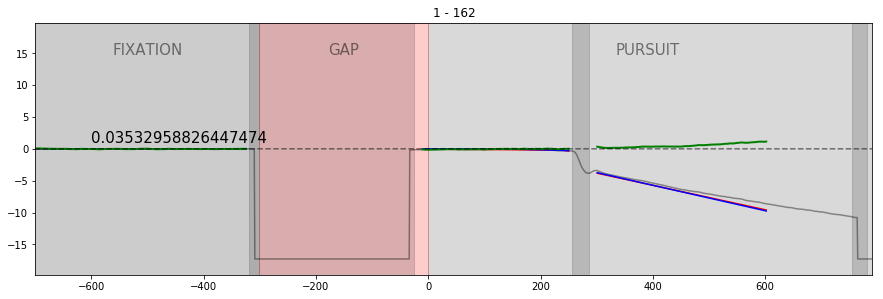

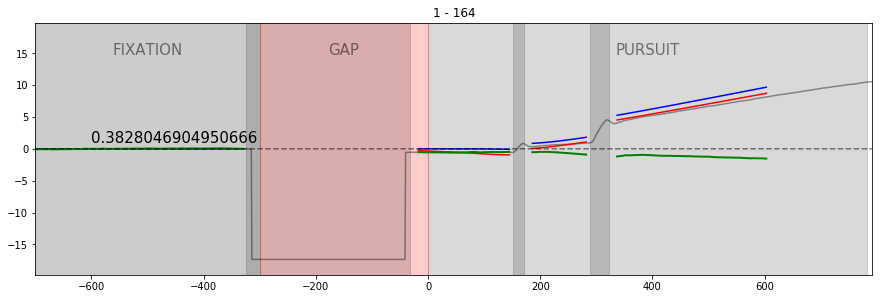

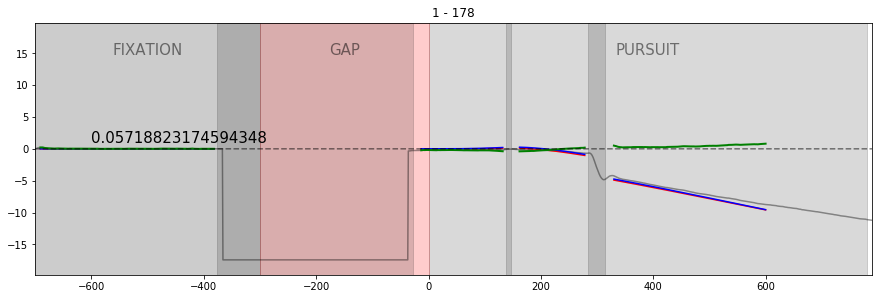

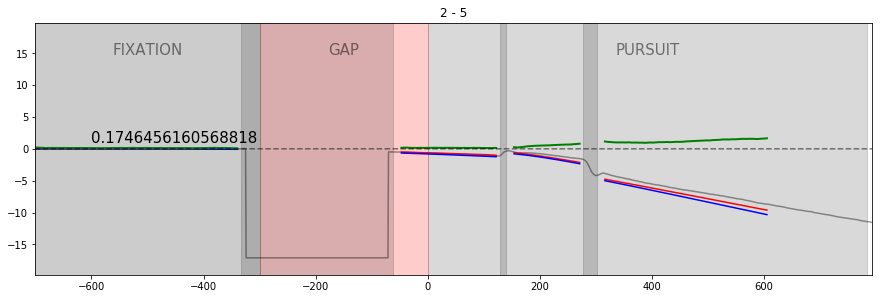

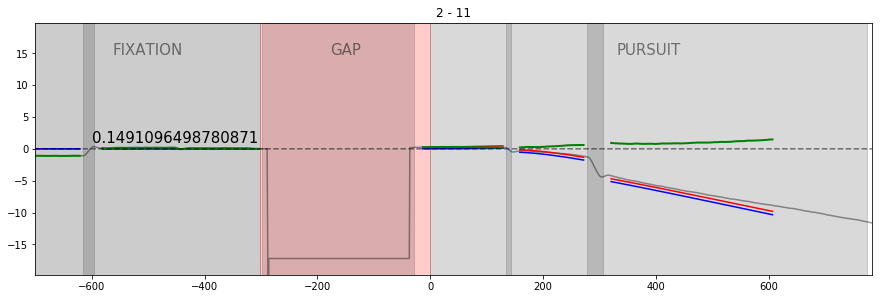

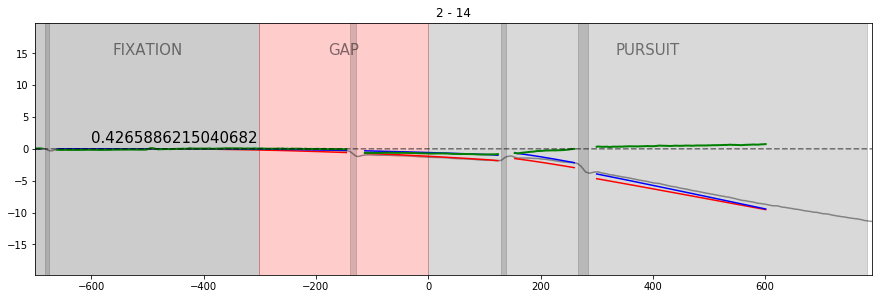

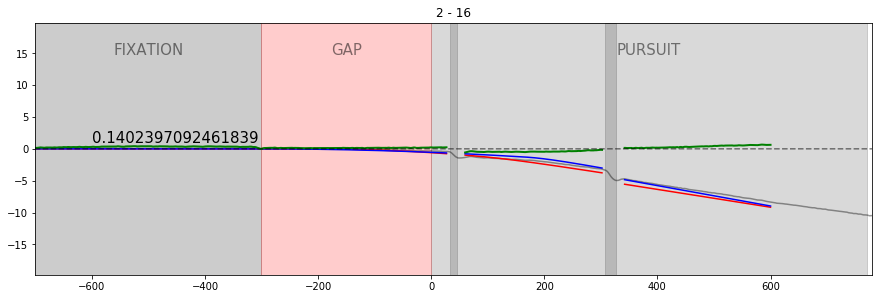

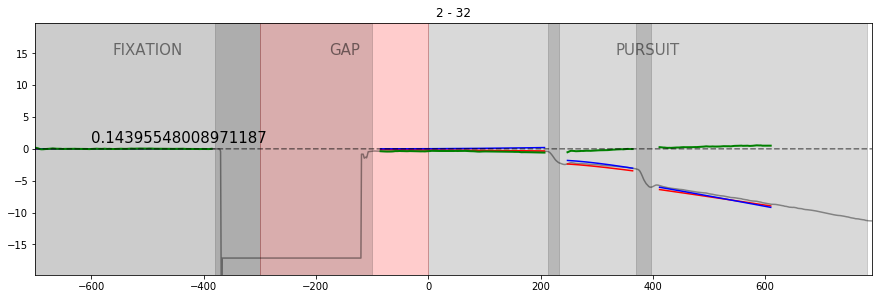

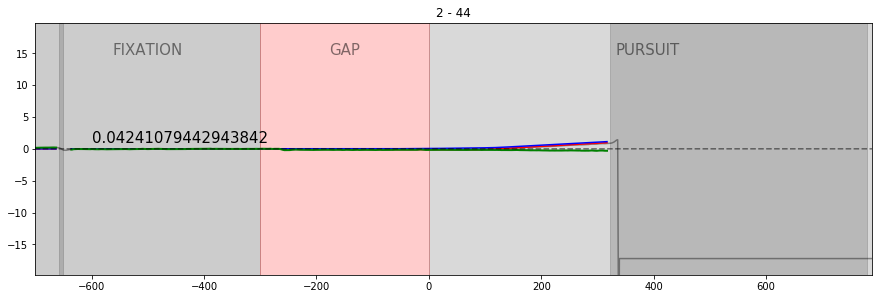

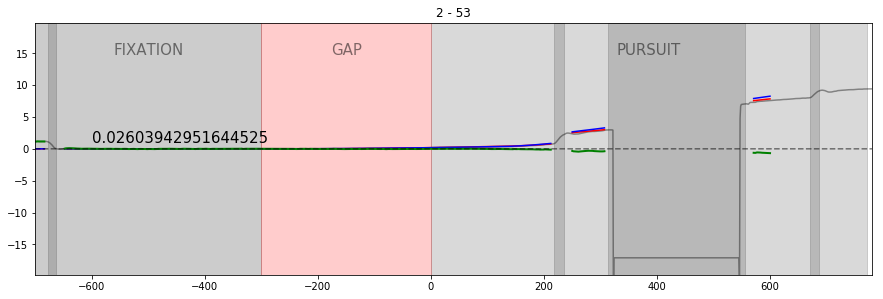

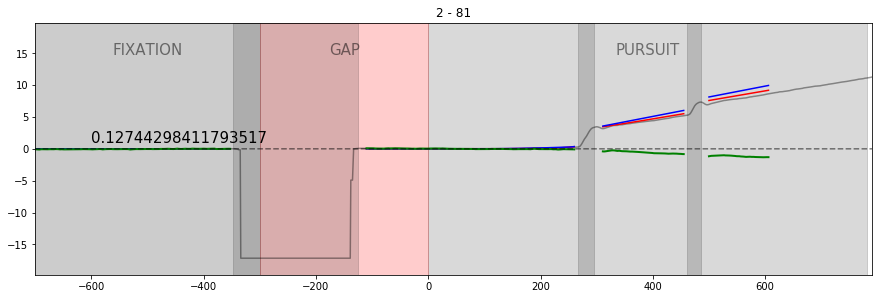

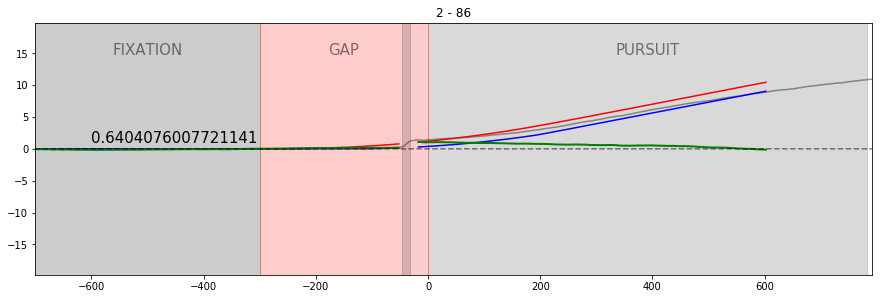

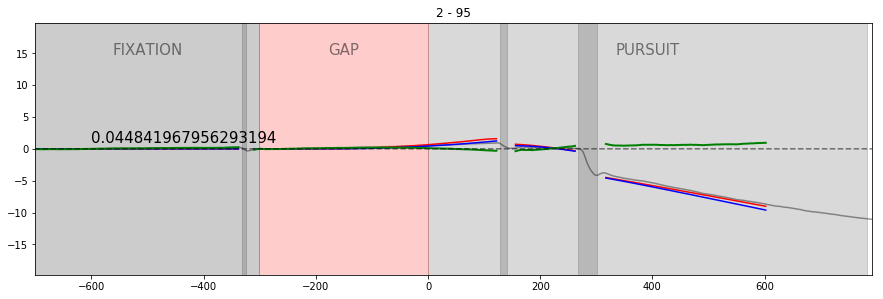

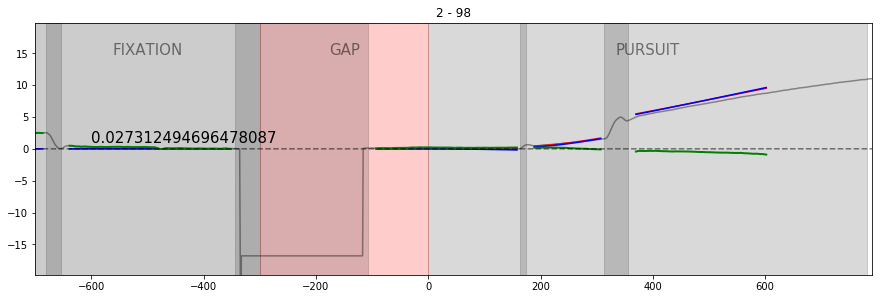

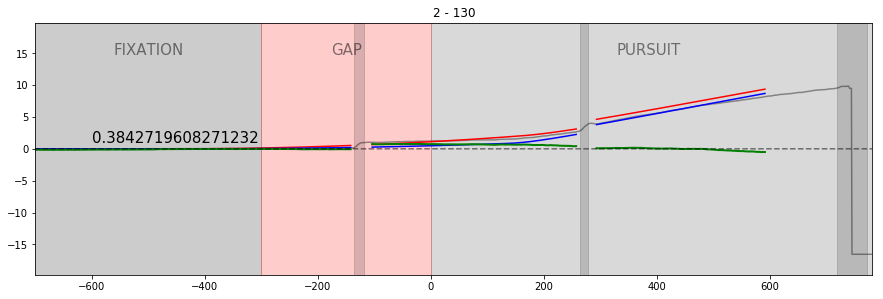

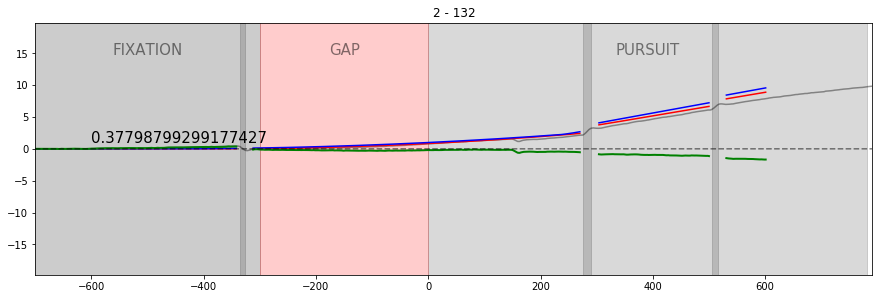

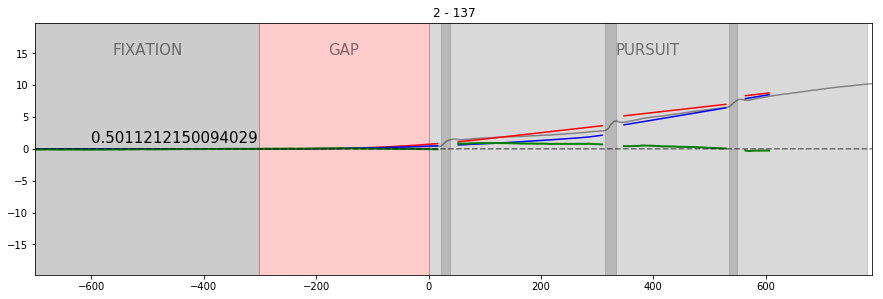

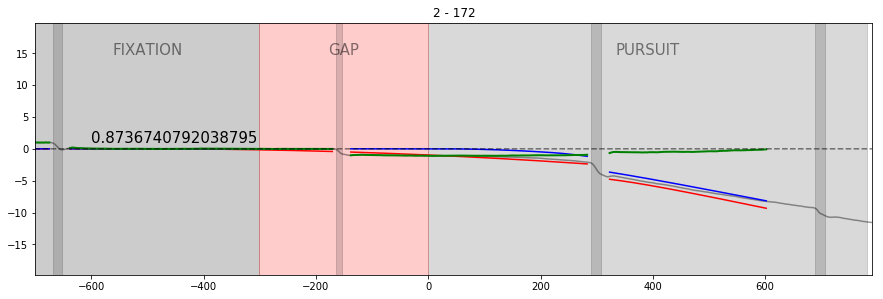

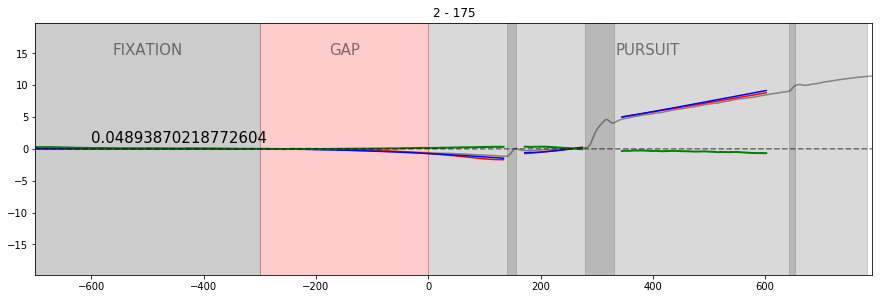

In [31]:
Bad_Fit['LB']

[[29, 36, 50, 52, 94, 100, 163, 170, 176, 190, 196, 198],
 [68, 72, 85, 91, 92, 132, 133, 135, 150, 155, 188],
 [52, 95, 113, 146, 154, 163]]